<a href="https://colab.research.google.com/github/mooniewexx/DL/blob/main/dl_blank_04_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade sympy

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

#### Загрузка датасета

определяем размер пакета (гиперпараметр) как 64 (каждый элемент в итерируемом объекте dataloader вернет пакет из 64 признаков и меток)

In [ ]:
batch_size = 64
lr = 0.001
epochs = 10


normalize = transforms.Lambda(lambda x: x / 255.)

transform = transforms.Compose([transforms.ToTensor(), normalize]) # композиция преобразований - тензоры -> нормализация

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # объект загрузки данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.21MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Выведем изображения с метками:

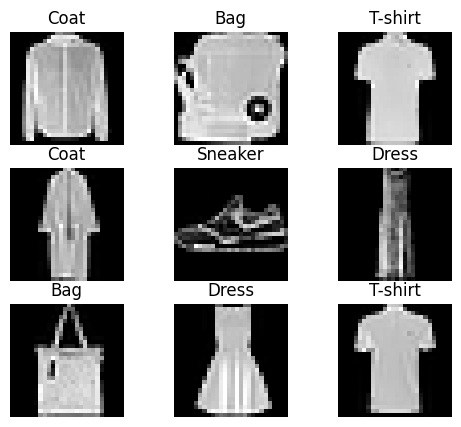

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (6,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Посмотрим на размер одного батча:

In [ ]:

# Инициализация переменных для хранения значений потерь и точности
epochs = 5
train_losses, test_losses = [], []
train_accs, test_accs = [], []
train_labels, train_preds = [], []
test_labels, test_preds = [], []

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_test = 0
        total_test = 0

        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_test = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_test += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

                test_labels.extend(labels.cpu().numpy())
                test_preds.extend(predicted.cpu().numpy())

        # Вычисляем точность, f1_score и MAE для тренировки и теста
        accuracy_train = 100 * correct_train / total_train
        accuracy_test = 100 * correct_test / total_test
        train_accs.append(accuracy_train)
        test_accs.append(accuracy_test)

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_test = f1_score(test_labels, test_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_test = mean_absolute_error(test_labels, test_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train /= len(train_loader)
        epoch_loss_test /= len(test_loader)

        train_losses.append(epoch_loss_train)
        test_losses.append(epoch_loss_test)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f} | '
              f'Train Acc: {accuracy_train:.2f}%, Test Acc: {accuracy_test:.2f}% | '
              f'F1 Train: {f1_train:.4f}, F1 Test: {f1_test:.4f} | '
              f'MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f} | '
              f'Time: {elapsed_time:.2f}s')

train_model(model, train_loader, test_loader, criterion, optimizer, epochs)

- N — количество образцов (примеров) в мини-батче.
- C — количество каналов (например, RGB для цветных изображений или 1 для черно-белых).
- H — высота изображения.
- W — ширина изображения.

Размер X в виде [N, C, H, W]: torch.Size([64, 1, 28, 28])
Размер y: torch.Size([64]) <built-in method type of Tensor object at 0x7d26fabe4270>



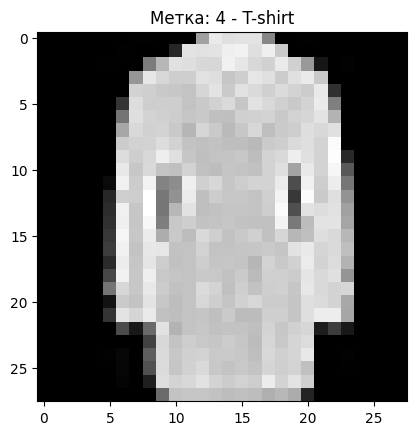


Размер массива меток: torch.Size([64])


In [ ]:
for X, y in train_loader:
    train_features, train_labels = next(iter(train_loader)) # получение первых элементов
    print(f'Размер X в виде [N, C, H, W]: {X.shape}')
    print(f'Размер y: {y.shape} {y.type}\n')

    image = train_features[0].squeeze() # первое изображение
    label = train_labels[0]             # первая метка
    sample_idx= torch.randint((label), size = (1,)).item()  # случайный индекс для отображения

    plt.title(f"Метка: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"\nРазмер массива меток: {train_labels.size()}")
    break

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # Входной слой -> Скрытый слой 1
            nn.ReLU(),
            nn.Linear(512, 256),  # Скрытый слой 1 -> Скрытый слой 2
            nn.ReLU(),
            nn.Linear(256, 10)  # Скрытый слой 2 -> Выходной слой (10 классов)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # преобразуем изображение 28x28 в вектор 784
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.linear_relu_stack(x)
        return x

####  Архитектура модели для решения задачи

также можно использовать nn.Flatten - преобразует двумерное изображение 28x28 в непрерывный массив из 784 значений пикселей. Размер мини-партии (при dim = 0) сохраняется.

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # Входной слой -> Скрытый слой 1
            nn.ReLU(),
            nn.Linear(512, 256),  # Скрытый слой 1 -> Скрытый слой 2
            nn.ReLU(),
            nn.Linear(256, 10)  # Скрытый слой 2 -> Выходной слой (10 классов)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

#### Количество параметров модели

поскольку это проблема классификации, мы используем nn.CrossEntropyLoss, которая является комбинацией nn.LogSoftmax и nn.NLLLoss(отрицательное логарифмическое правдоподобие), которая нормализует логиты и вычисляет ошибку прогнозирования

In [ ]:
model = FashionMNISTModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
num_params = sum(param.numel() for param in model.parameters())
print(f"Количество параметров в модели: {num_params}")

Количество параметров в модели: 535818


#### Обучение модели

In [ ]:
import time
from tqdm import tqdm

los = []

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        epoch_loss= 0.0
        correct = 0
        total = 0

        start_time = time.time()

        # X_batch - images
        # y_batch - labels
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss+= loss.item()

            # вычисление точности
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # если истинн. совп. с предск.

        epoch_loss = epoch_loss/ len(train_loader)
        los.append(epoch_loss)    # cредняя потеря на эпоху
        accuracy = 100 * correct / total

        elapsed_time = time.time() - start_time

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {elapsed_time:.2f}s')

    #return los

#los = train_model(model, train_loader, criterion, optimizer, epochs)
train_model(model, train_loader, criterion, optimizer, epochs)

Epoch [1/10], Loss: 0.9601, Accuracy: 64.15%, Time: 21.38s


Epoch [2/10], Loss: 0.6052, Accuracy: 77.81%, Time: 21.39s


Epoch [3/10], Loss: 0.5313, Accuracy: 80.84%, Time: 20.61s


Epoch [4/10], Loss: 0.4869, Accuracy: 82.43%, Time: 21.48s


Epoch [5/10], Loss: 0.4567, Accuracy: 83.44%, Time: 21.55s


Epoch [6/10], Loss: 0.4330, Accuracy: 84.44%, Time: 21.39s


Epoch [7/10], Loss: 0.4135, Accuracy: 85.00%, Time: 21.71s


Epoch [8/10], Loss: 0.3983, Accuracy: 85.67%, Time: 20.41s


Epoch [9/10], Loss: 0.3827, Accuracy: 86.16%, Time: 21.54s


Epoch [10/10], Loss: 0.3704, Accuracy: 86.64%, Time: 21.07s


#### График функции потерь по эпохам

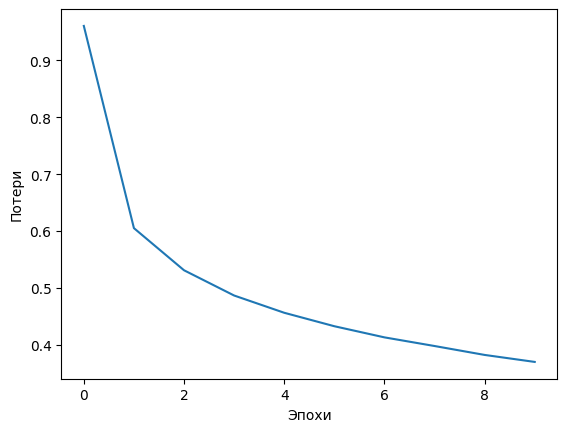

In [ ]:
plt.plot(los)
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

#### Матрица ошибок и значение accuracy на тестовом множестве

Accuracy на тестовом множестве: 85.20%



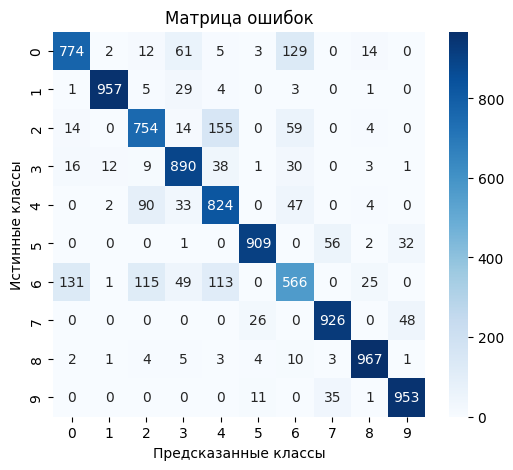

In [ ]:
# тестирование модели и вычисление accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        # X_batch - images
        # y_batch - labels
        for images, labels in test_loader:
            y_pred = model(images)

            # вычисление точности
            _, predicted = torch.max(y_pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100
    return accuracy, all_labels, all_preds

accuracy, labels, preds = evaluate_model(model, test_loader)
print(f'Accuracy на тестовом множестве: {accuracy:.2f}%\n')


conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

#### Демонстрация работы модели: выводим несколько изображений, правильный класс и класс, предсказанный моделью

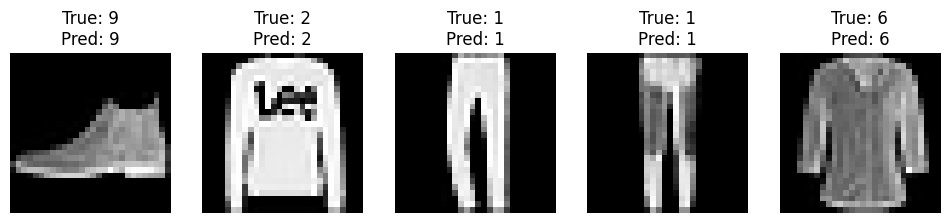

In [ ]:
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))

    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i].item()}\nPred: {preds[i].item()}')
        ax.axis('off')
    plt.show()

visualize_predictions(model, test_loader)


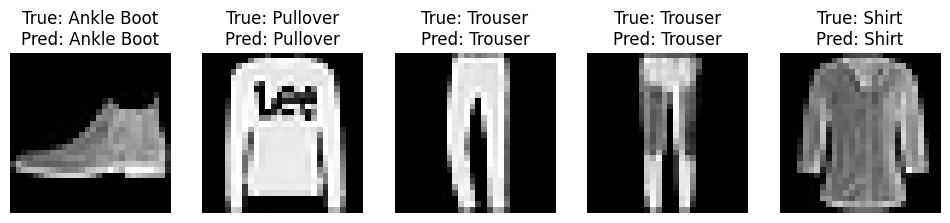

In [ ]:
def visualize_predictions(model, test_loader, num_images=5, labels_map=None):
    model.eval()
    images, labels = next(iter(test_loader))

    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    if labels_map is not None:
        labels = [labels_map[l.item()] for l in labels]
        preds = [labels_map[p.item()] for p in preds]

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i]}\nPred: {preds[i]}')
        ax.axis('off')
    plt.show()

visualize_predictions(model, test_loader, labels_map=labels_map)

#### Сохранение модели

In [ ]:
torch.save(model.state_dict(), "NNmodel_001.pth")
print("Saved PyTorch Model State to NNmodel_001.pth")

Saved PyTorch Model State to NNmodel_001.pth


In [ ]:
NNmodel = FashionMNISTModel()
NNmodel.load_state_dict(torch.load("NNmodel_001.pth"))

<ipython-input-15-9939a10e1716>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NNmodel.load_state_dict(torch.load("NNmodel_001.pth"))


<All keys matched successfully>

#### черновик

пример: https://www.kaggle.com/code/adrynh/pytorch-tutorial-with-fashion-mnist#Pytorch-Tutorial

его ноутбук: https://colab.research.google.com/drive/19TMi1OYuEqD8mmftkvmMr-3tEl9JgT1E?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Параметры
batch_size = 64
lr = 0.001
epochs = 10

# Загрузка данных Fashion MNIST
transform = transforms.Compose([transforms.ToTensor(), normalize]) # transforms.Normalize((0.5,), (0.5,))])
fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Сплит на обучающую и валидационную выборки
train_size = int(0.8 * len(fashion_mnist))
val_size = len(fashion_mnist) - train_size
train_dataset, val_dataset = random_split(fashion_mnist, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Тестовый набор
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определение модели
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # Входной слой -> Скрытый слой 1
        self.fc2 = nn.Linear(512, 256)  # Скрытый слой 1 -> Скрытый слой 2
        self.fc3 = nn.Linear(256, 10)  # Скрытый слой 2 -> Выходной слой (10 классов)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Преобразуем изображение 28x28 в вектор 784
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FashionMNISTModel()

criterion = nn.CrossEntropyLoss()  # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=lr)

# Обучение модели
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    los = []

    for epoch in range(epochs):
        epoch_loss= 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Обнуление градиентов

            # Прямой проход
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            epoch_loss+= loss.item()

        epoch_loss = epoch_loss/ len(train_loader)
        los.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

    return los

# Обучение модели
los = train_model(model, train_loader, criterion, optimizer, epochs)

# Визуализация функции потерь
plt.plot(los)
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

# Функция для оценки модели и вычисления accuracy
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            y_pred = model(images)
            _, predicted = torch.max(y_pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100
    return accuracy, all_labels, all_preds

# Оценка модели на валидационном множестве
val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader)
print(f'Accuracy на валидационном множестве: {val_accuracy:.2f}%')

# Оценка модели на тестовом множестве
test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader)
print(f'Accuracy на тестовом множестве: {test_accuracy:.2f}%')


KeyboardInterrupt: 

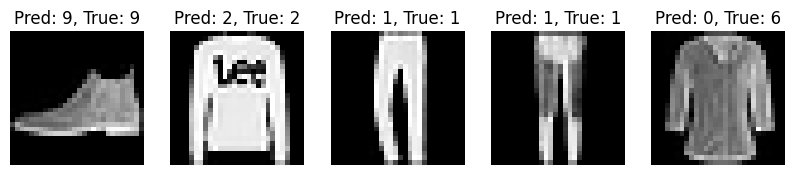

In [ ]:
# Визуализация предсказаний модели
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Визуализация предсказаний
visualize_predictions(model, test_loader)

In [ ]:
model = FashionMNISTModel()

criterion = nn.CrossEntropyLoss()  # ф.потерь
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    los = []

    for epoch in range(epochs):
        epoch_loss= 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Обнуление градиентов

            # Прямой проход
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            epoch_loss+= loss.item()

        epoch_loss = epoch_loss/ len(train_loader)
        los.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

    return los

# Обучение модели
los = train_model(model, train_loader, criterion, optimizer, epochs)

# Визуализация функции потерь
plt.plot(los)
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

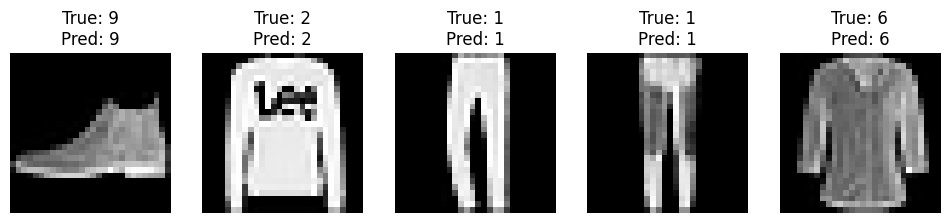

In [ ]:
# Визуализация предсказаний модели
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    # Вывод нескольких изображений с предсказаниями
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i].item()}\nPred: {preds[i].item()}')
        ax.axis('off')
    plt.show()

# Визуализация предсказаний
visualize_predictions(model, test_loader)

# Сохранение модели
#torch.save(model.state_dict(), 'fashion_mnist_model.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
class CNNFashionMNIST(nn.Module):
    def __init__(self):
        super(CNNFashionMNIST, self).__init__()

        # сверточные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # прохождение через сверточные слои с активацией и пулингом
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # преобразуем тензор для полносвязных слоев
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
train_size = int(0.8 * len(train_dataset))  # 80% для тренировки
val_size = len(train_dataset) - train_size  # 20% для валидации
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_size

48000

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
import seaborn as sns

train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0


        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())


        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train/ len(train_loader)
        epoch_loss_val = epoch_loss_val/ len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)


        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    #return train_losses, val_losses, val_labels, val_preds


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Train Loss: 0.5755, Val Loss: 0.5521,
 Train Acc: 78.64%, Val Acc: 80.17%,
 Train F1: 0.78, Val F1: 0.80,
 Train MAE: 0.6617, Val MAE: 0.6132, Time: 77.74s




Epoch [2/5], Train Loss: 0.5369, Val Loss: 0.5164,
 Train Acc: 80.22%, Val Acc: 81.10%,
 Train F1: 0.79, Val F1: 0.80,
 Train MAE: 0.6424, Val MAE: 0.6072, Time: 79.91s




Epoch [3/5], Train Loss: 0.5070, Val Loss: 0.4941,
 Train Acc: 81.34%, Val Acc: 81.95%,
 Train F1: 0.80, Val F1: 0.81,
 Train MAE: 0.6243, Val MAE: 0.6010, Time: 78.56s




Epoch [4/5], Train Loss: 0.4759, Val Loss: 0.4628,
 Train Acc: 82.83%, Val Acc: 83.19%,
 Train F1: 0.80, Val F1: 0.81,
 Train MAE: 0.6051, Val MAE: 0.5828, Time: 79.70s




Epoch [5/5], Train Loss: 0.4536, Val Loss: 0.4487,
 Train Acc: 83.64%, Val Acc: 83.83%,
 Train F1: 0.81, Val F1: 0.82,
 Train MAE: 0.5886, Val MAE: 0.5661, Time: 78.98s




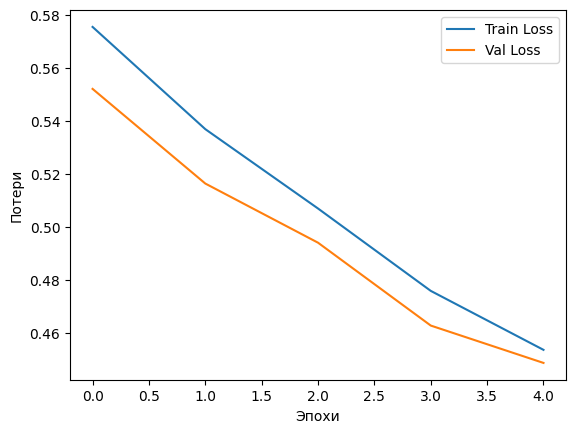

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

Accuracy на тестовом множестве: 83.03%



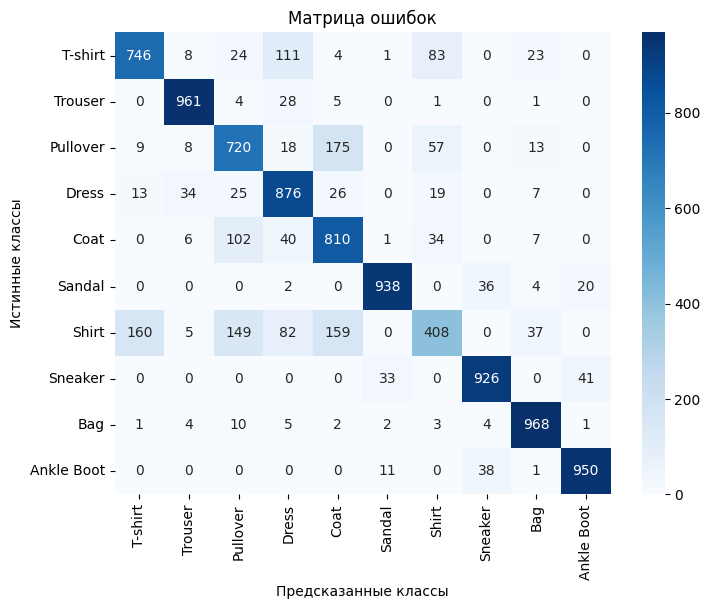

In [ ]:
# Оценка модели и вычисление точности
def evaluate_model(model, test_loader):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        # Проходим по тестовому датасету
        for images, labels in test_loader:
            y_pred = model(images)

            # Получаем предсказанные классы
            _, predicted = torch.max(y_pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Сохраняем истинные и предсказанные значения для дальнейшего анализа
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Вычисление точности
    accuracy = correct / total * 100
    return accuracy, all_labels, all_preds

# Тестирование модели и вывод метрик
accuracy, labels, preds = evaluate_model(model, test_loader)
print(f'Accuracy на тестовом множестве: {accuracy:.2f}%\n')

# Матрица ошибок
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

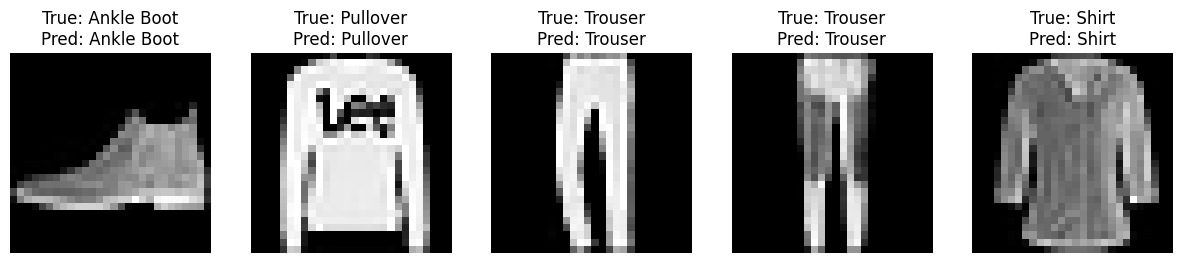

In [ ]:
import matplotlib.pyplot as plt

# визуализация предсказаний модели
def visualize_predictions(model, test_loader, num_images=5, labels_map=None):
    model.eval()  # переводим модель в режим оценки
    images, labels = next(iter(test_loader))  # получаем один батч изображений

    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    if labels_map is not None:
        # преобразуем метки классов в понятные имена
        labels = [labels_map[l.item()] for l in labels]
        preds = [labels_map[p.item()] for p in preds]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 6))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i]}\nPred: {preds[i]}')
        ax.axis('off')
    plt.show()

visualize_predictions(model, test_loader, num_images=5, labels_map=labels_map)

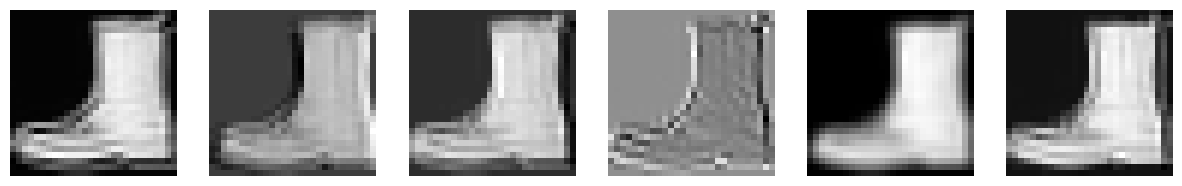

In [ ]:
def visualize_conv_filters(model, images):
    with torch.no_grad():
        conv1_out = model.conv1(images)
        fig, axes = plt.subplots(1, 6, figsize=(15, 15))
        for i in range(6):
            ax = axes[i]
            ax.imshow(conv1_out[0][i].cpu().numpy(), cmap='gray')
            ax.axis('off')
    plt.show()

# Возьмем батч данных из train_loader
images, _ = next(iter(train_loader))
visualize_conv_filters(model, images)


In [ ]:
torch.save(model.state_dict(), "CNNmodel_001.pth")
print("Saved PyTorch Model State to CNNmodel_001.pth")

Saved PyTorch Model State to CNNmodel_001.pth


In [ ]:
CNNmodel = CNNFashionMNIST()
CNNmodel.load_state_dict(torch.load("CNNmodel_001.pth"))

<ipython-input-43-ee1a48356787>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNNmodel.load_state_dict(torch.load("CNNmodel_001.pth"))


<All keys matched successfully>

##  2. Классификация изображений (датасет CIFAR 10)


### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

#### Загрузка датасета с нормализацией

применяем масштабирование и центрирование: изображения CIFAR-10 представлены в диапазоне 0, 255. для того чтобы лучше использовать возможности нейронных сетей, работающих в ограниченном диапазоне(как ReLU), требуется масштабировать и центрировать данные, нормализация до -1, 1 позволяет сделать это

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # нормализация на [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# training dataset - 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

Посмотрим на изображения:

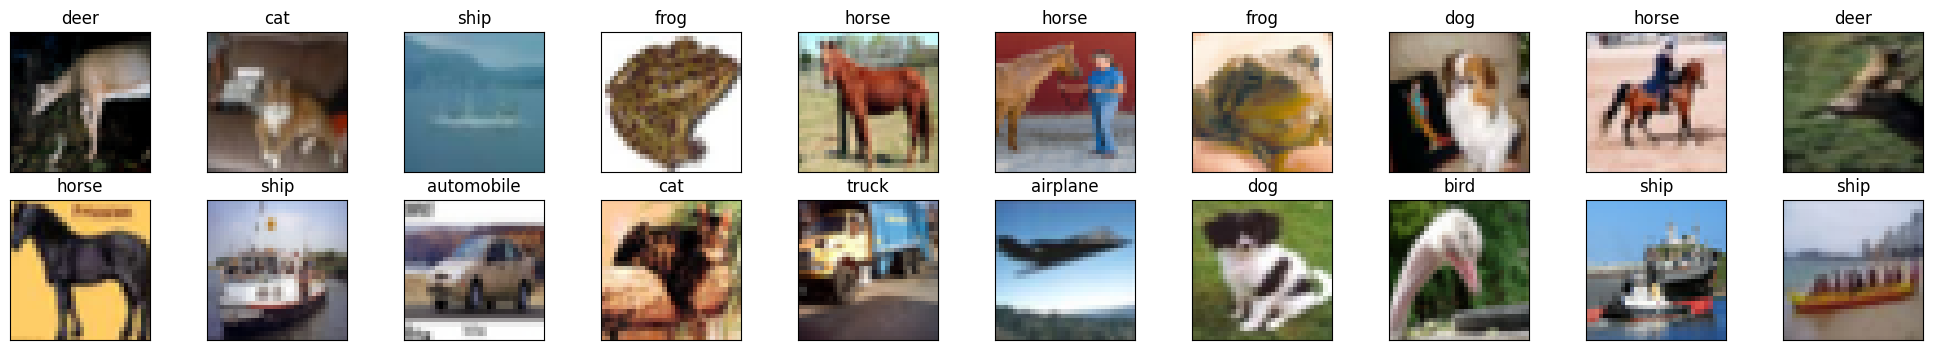

In [ ]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

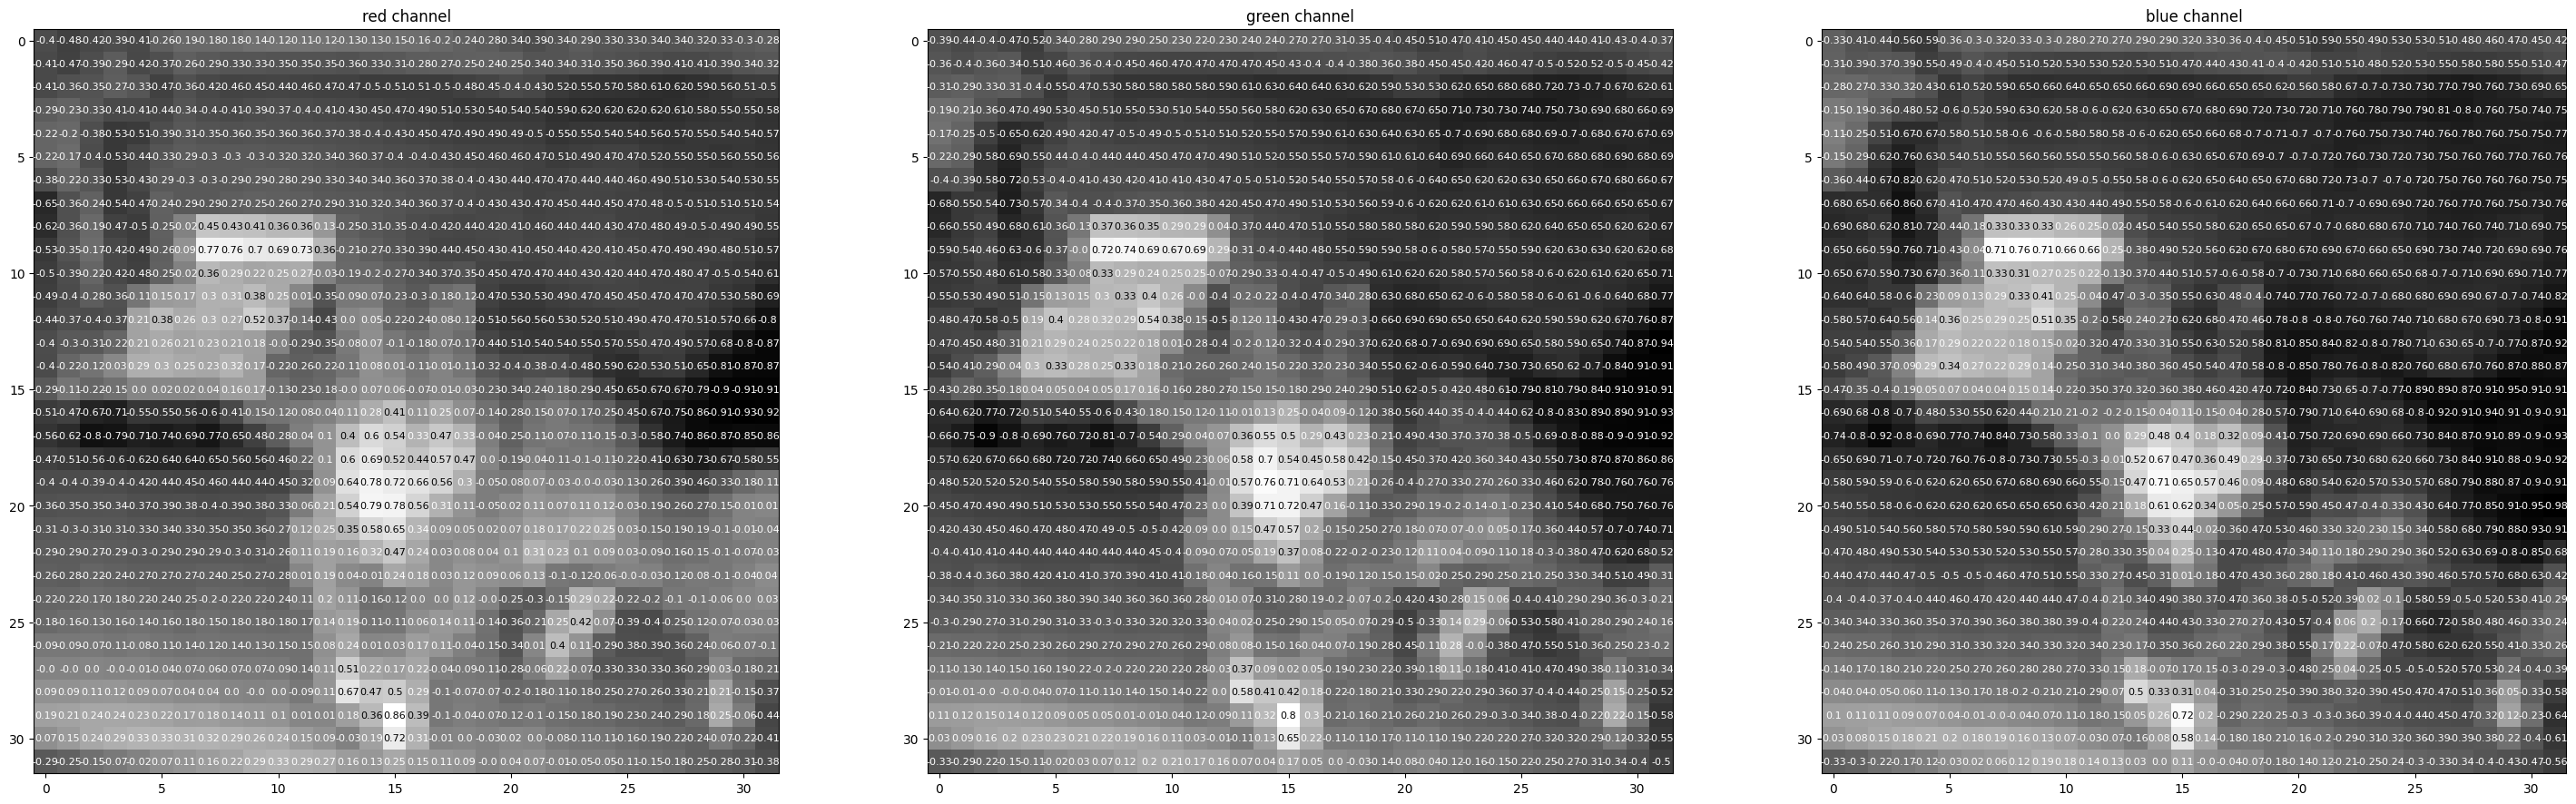

In [ ]:
rgb_img = np.squeeze(images[1])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

####  Архитектура модели для решения задачи

In [ ]:
class CIFAR10_FFNN(nn.Module):
    def __init__(self):
        super(CIFAR10_FFNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  # Входной слой (32x32x3 пиксела -> 1024 единицы)
        self.fc2 = nn.Linear(1024, 512)          # Скрытый слой 1
        self.fc3 = nn.Linear(512, 256)           # Скрытый слой 2
        self.fc4 = nn.Linear(256, 128)           # Скрытый слой 3
        self.fc5 = nn.Linear(128, 10)            # Выходной слой (10 классов)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

#### Количество параметров модели

поскольку это проблема классификации, мы используем nn.CrossEntropyLoss, которая является комбинацией nn.LogSoftmax и nn.NLLLoss(отрицательное логарифмическое правдоподобие), которая нормализует логиты и вычисляет ошибку прогнозирования

In [ ]:
model = CIFAR10_FFNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество параметров в модели: {count_parameters(model)}")

Количество параметров в модели: 3837066


#### Обучение модели

In [ ]:
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        # X_batch - images
        # y_batch - labels
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()

            # вычисление точности
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # если истинн. совп. с предск.

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total

        # val step
        model.eval()
        val_loss = 0.0
        correct_v = 0
        total_v = 0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                val_loss += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_v += labels.size(0)
                correct_v += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct_v / total_v

        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {elapsed_time:.2f}s")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1/5, Train Loss: 0.6341, Train Accuracy: 77.59%, Val Loss: 1.0220, Val Accuracy: 67.61%, Time: 62.77s


Epoch 2/5, Train Loss: 0.5703, Train Accuracy: 79.96%, Val Loss: 1.1128, Val Accuracy: 66.25%, Time: 59.00s


Epoch 3/5, Train Loss: 0.5219, Train Accuracy: 81.59%, Val Loss: 1.1327, Val Accuracy: 65.21%, Time: 58.96s


Epoch 4/5, Train Loss: 0.4714, Train Accuracy: 83.22%, Val Loss: 1.2718, Val Accuracy: 64.83%, Time: 58.21s


Epoch 5/5, Train Loss: 0.4402, Train Accuracy: 84.50%, Val Loss: 1.3564, Val Accuracy: 64.17%, Time: 59.36s


#### График функции потерь по эпохам

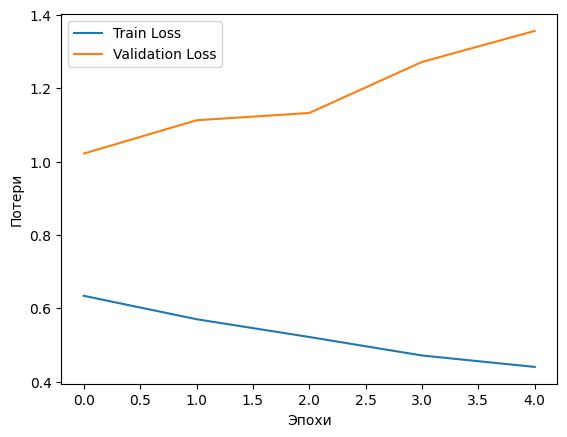

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

#### Матрица ошибок и значение accuracy на тестовом множестве

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            y_pred = model(images)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = test_model(model, test_loader)

Test Accuracy: 0.5261
Матрица ошибок:
[[623  64  35  51  30  14  25  13  84  61]
 [ 32 721  13  24  12  20  17  12  34 115]
 [ 89  24 340  99 146 124  85  50  22  21]
 [ 19  21  55 344  58 257 136  61  20  29]
 [ 40  14 131  77 447  78 114  68  18  13]
 [ 14   8  53 227  53 482  67  59  18  19]
 [ 15  18  66  90  66  77 625  17  10  16]
 [ 36  20  36  81 103 115  29 525  13  42]
 [105 110   9  35  32  25  12   7 603  62]
 [ 40 205  15  45  22  33  32  22  35 551]]


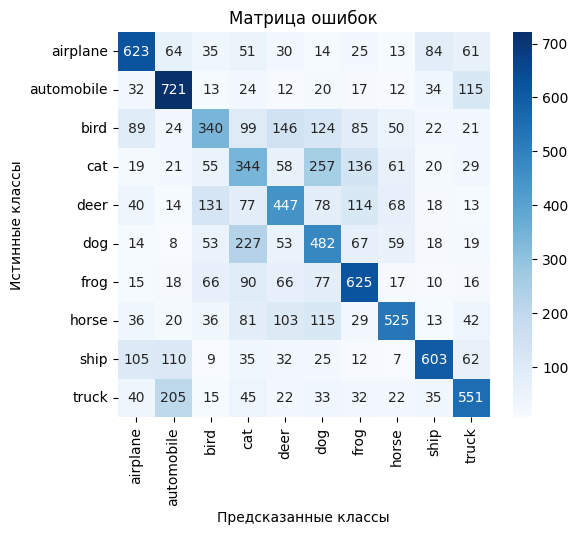

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Test Accuracy: {accuracy:.4f}')
print('Матрица ошибок:')
print(conf_matrix)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

#### Демонстрация работы модели: выводим несколько изображений, правильный класс и класс, предсказанный моделью

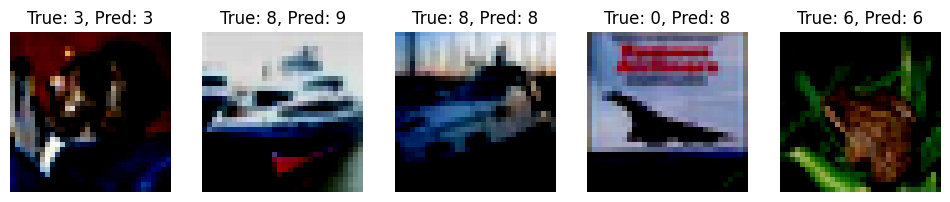

In [ ]:
def plot_sample_images(test_loader, predictions, true_labels, num_images=5):
    test_images, _ = next(iter(test_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

    for i in range(num_images):
        axes[i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))  # Transpose to plot correctly
        axes[i].set_title(f"True: {true_labels[i]}, Pred: {predictions[i]}")
        axes[i].axis('off')

plot_sample_images(test_loader, predictions, true_labels)

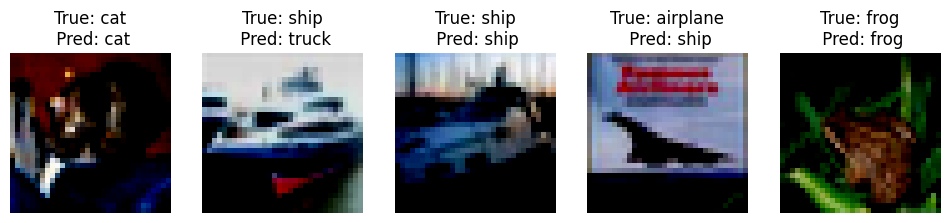

In [ ]:
def plot_sample_images(test_loader, predictions, true_labels, classes, num_images=5):
    test_images, _ = next(iter(test_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

    for i in range(num_images):
        axes[i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))  # транспон для прав графика
        predicted_class = classes[predictions[i]]
        true_class = classes[true_labels[i]]
        axes[i].set_title(f"True: {true_class}\n Pred: {predicted_class}")
        axes[i].axis('off')

plot_sample_images(test_loader, predictions, true_labels, classes)

#### Сохранение модели

In [ ]:
torch.save(model.state_dict(), 'cifar10_ffnn_model.pth')
print("Saved PyTorch Model State to cifar10_ffnn_model.pth")

Saved PyTorch Model State to cifar10_ffnn_model.pth


In [ ]:
cifar_model = CIFAR10_FFNN()
cifar_model.load_state_dict(torch.load('cifar10_ffnn_model.pth'))

<ipython-input-69-ced4c52d9bf6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cifar_model.load_state_dict(torch.load('cifar10_ffnn_model.pth'))


<All keys matched successfully>

#### черновик

пример: https://github.com/simoninithomas/cifar-10-classifier-pytorch/blob/master/PyTorch%20Cifar-10%20Classifier.ipynb

In [ ]:
from matplotlib.pyplot import imshow

In [ ]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data",
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data",
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
#train_sampler = SubsetRandomSampler(train_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                          #sampler = train_sampler,
                                          num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                          #sampler = valid_sampler,
                                          num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size = batch_size,
                                          num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # нормализация на [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

100%|██████████| 170M/170M [00:02<00:00, 73.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # Первый сверточный слой
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Первый сверточный + пулинг
        x = self.pool(F.relu(self.conv2(x)))  # Второй сверточный + пулинг
        x = x.view(-1, 64 * 8 * 8)           # Преобразование в плоский вид
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = CIFAR10_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество параметров в модели: {count_parameters(model)}")

Количество параметров в модели: 2250954


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
import seaborn as sns

train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0

        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train / len(train_loader)
        epoch_loss_val = epoch_loss_val / len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    # Return метрики
    #return train_losses, val_losses, train_labels, train_preds, val_labels, val_preds

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Train Loss: 1.3949, Val Loss: 1.1004,
 Train Acc: 49.32%, Val Acc: 60.80%,
 Train F1: 0.49, Val F1: 0.60,
 Train MAE: 1.8467, Val MAE: 1.4164, Time: 106.94s




Epoch [2/5], Train Loss: 0.9693, Val Loss: 0.9575,
 Train Acc: 65.53%, Val Acc: 66.67%,
 Train F1: 0.57, Val F1: 0.63,
 Train MAE: 1.5301, Val MAE: 1.2988, Time: 118.48s




Epoch [3/5], Train Loss: 0.7659, Val Loss: 0.8841,
 Train Acc: 72.77%, Val Acc: 69.66%,
 Train F1: 0.62, Val F1: 0.65,
 Train MAE: 1.3346, Val MAE: 1.2077, Time: 118.38s




Epoch [4/5], Train Loss: 0.5910, Val Loss: 0.8703,
 Train Acc: 79.17%, Val Acc: 70.32%,
 Train F1: 0.67, Val F1: 0.67,
 Train MAE: 1.1762, Val MAE: 1.1502, Time: 117.98s




Epoch [5/5], Train Loss: 0.4241, Val Loss: 0.9522,
 Train Acc: 85.17%, Val Acc: 70.76%,
 Train F1: 0.70, Val F1: 0.67,
 Train MAE: 1.0392, Val MAE: 1.1161, Time: 116.58s




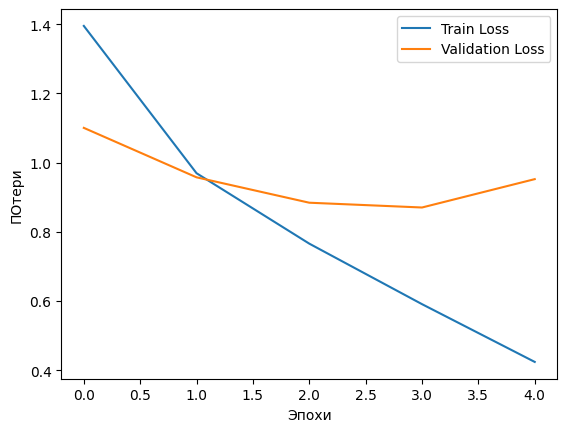

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('ПОтери')
plt.show()

Матрица ошибок:
[[727  18  79  24  17  13  12  17  50  43]
 [ 17 791  19  14   1   5   8   3  17 125]
 [ 37   2 627  72  55  76  75  37   6  13]
 [ 22   7  66 483  41 229  78  33  12  29]
 [ 16   2 128  80 543  68  92  60   6   5]
 [ 14   6  43 141  23 678  29  53   6   7]
 [  4   3  39  45  26  35 831   5   4   8]
 [ 11   6  35  33  36  85   7 769   0  18]
 [ 79  43  20  18   4  10  10   4 769  43]
 [ 34  64   7  12   3  11   8  20  11 830]]

Accuracy на тестовом множестве: 70.48 %
Test F1 Score: 0.7043
Test MAE: 1.0086



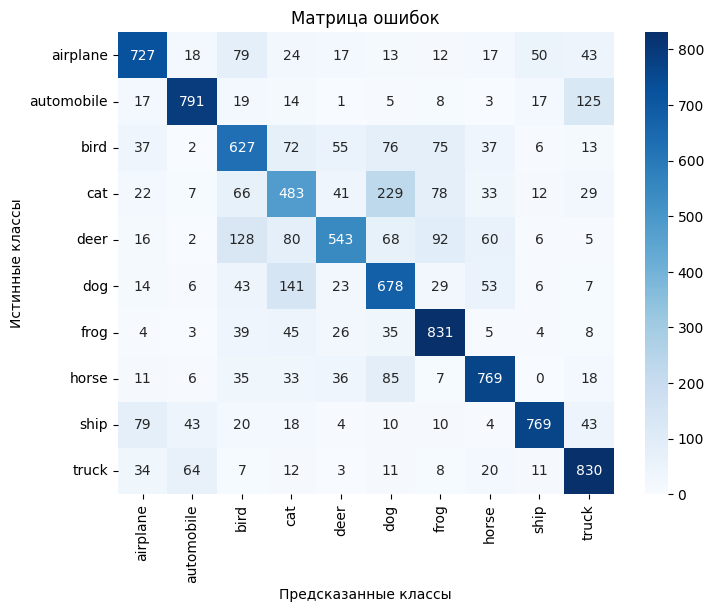

In [ ]:
from sklearn.metrics import accuracy_score

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            y_pred = model(images)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = test_model(model, test_loader)

# Оценка модели на тестовых данных
accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
mae = mean_absolute_error(true_labels, predictions)

print('Матрица ошибок:')
print(conf_matrix)

print(f'\nAccuracy на тестовом множестве: {100*accuracy:.2f} %')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test MAE: {mae:.4f}\n')


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

Смотрим на работу первого сверточного слоя:

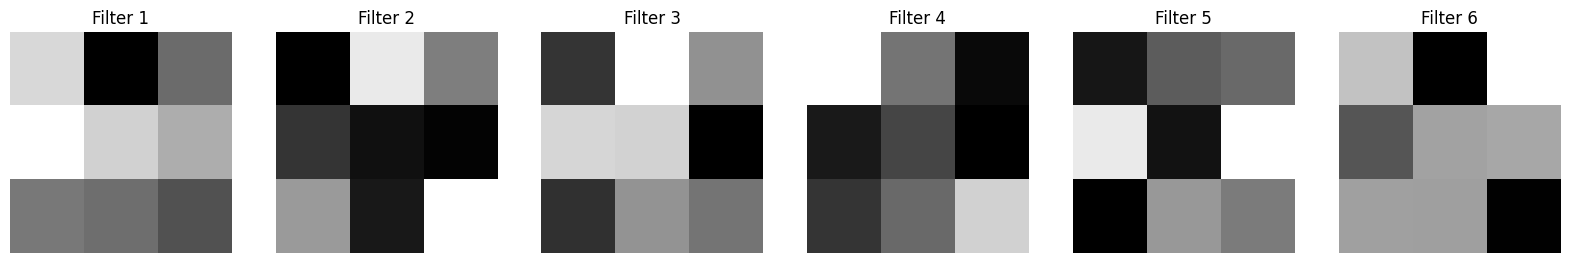

In [ ]:
def visualize_first_layer(model, num_filters=6):
    with torch.no_grad():
        filters = model.conv1.weight.data.cpu().numpy()
        fig, axes = plt.subplots(1, num_filters, figsize=(20, 20))
        for i in range(num_filters):
            axes[i].imshow(filters[i, 0, :, :], cmap='gray')
            axes[i].set_title(f'Filter {i+1}')
            axes[i].axis('off')
    plt.show()

visualize_first_layer(model)

In [ ]:
torch.save(model.state_dict(), 'cifar10_cnn_model.pth')
print("Saved PyTorch Model State to cifar10_cnn_model.pth")

Saved PyTorch Model State to cifar10_cnn_model.pth


In [ ]:
cifar_model = CIFAR10_CNN()
cifar_model.load_state_dict(torch.load('cifar10_cnn_model.pth'))

<ipython-input-65-17217ba09fd5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cifar_model.load_state_dict(torch.load('cifar10_cnn_model.pth'))


<All keys matched successfully>

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/fruits.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2684/2684 [00:01<00:00, 2357.26it/s]


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((100, 100)),    # Приводим к единому размеру
    transforms.ToTensor(),            # Преобразование в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
])

full_dataset = datasets.ImageFolder('/content/fruits', transform=transform)

train_size = int(0.7 * len(full_dataset))  # 70% для обучения
val_size = int(0.15 * len(full_dataset))   # 15% для валидации
test_size = len(full_dataset) - train_size - val_size  # Остальные 15% для теста

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

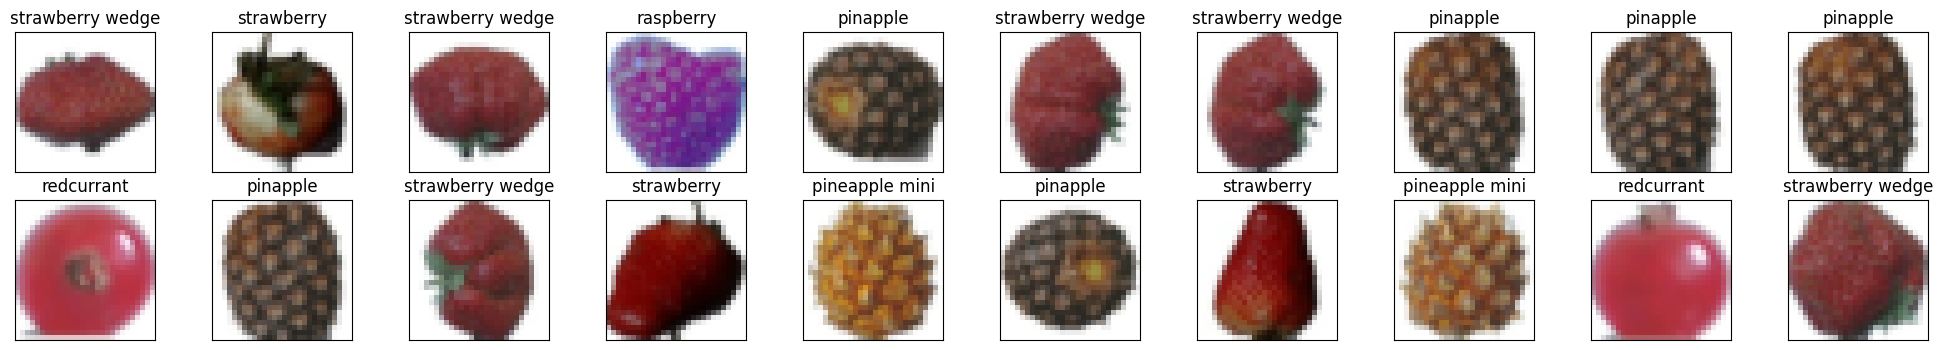

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['pinapple', 'pineapple mini', 'raspberry', 'redcurrant', 'strawberry', 'strawberry wedge']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

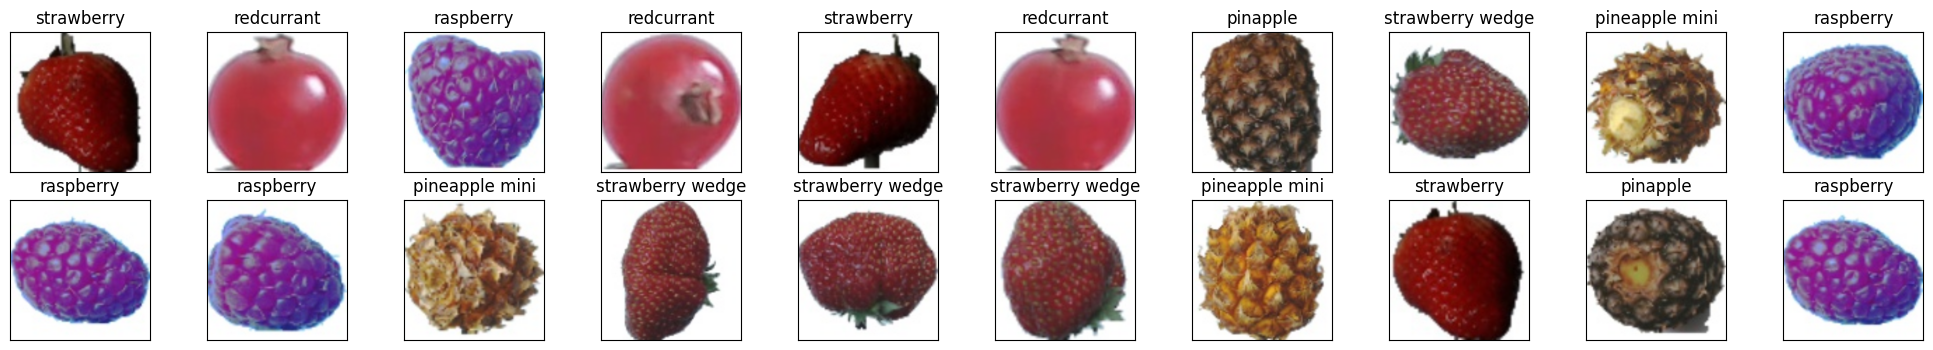

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['pinapple', 'pineapple mini', 'raspberry', 'redcurrant', 'strawberry', 'strawberry wedge']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Первый сверточный блок
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling для уменьшения размера изображения
        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 100 * 100, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)  # Преобразуем тензор в вектор
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Определение количества классов (например, из train_dataset)
#num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=6)#num_classes)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Первый сверточный блок
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Вход: 28x28x3 -> Выход: 28x28x32
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling для уменьшения размера изображения
        # Второй сверточный блок
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Вход: 28x28x32 -> Выход: 28x28x64

        # После двух слоев свертки и подвыборки размер изображения будет 7x7
        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Учитываем новый размер
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # После conv1 -> 28x28 -> MaxPool -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # После conv2 -> 14x14 -> MaxPool -> 7x7
        x = x.view(-1, 64 * 7 * 7)  # Преобразуем тензор в вектор
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Определение количества классов (например, из train_dataset)
# num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=6)  # num_classes)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Первый сверточный блок
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, padding=1)  # Вход: 100x100x3 -> Выход: 100x100x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=8, padding=1)  # Вход: 100x100x32 -> Выход: 100x100x64
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling для уменьшения размера изображения

        # После двух слоев свертки и подвыборки размер изображения будет 25x25
        self.fc1 = nn.Linear(64 * 25 * 25, 512)  # Учитываем новый размер
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # После conv1 -> 100x100 -> MaxPool -> 50x50
        x = self.pool(F.relu(self.conv2(x)))  # После conv2 -> 50x50 -> MaxPool -> 25x25
        x = x.view(-1, 64 * 25 * 25)  # Преобразуем тензор в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Определение количества классов (например, из train_dataset)
# num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=6)  # num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
    nn.Conv2d(3, 16, 8), # 8 25 25
    nn.ReLU(),
    nn.MaxPool2d(2, 2),#8 12 12
    nn.Conv2d(16, 32, 8),#16 5 5
    nn.ReLU(),
    nn.MaxPool2d(2, 2), #16 2 2
    nn.Flatten(),
    nn.Linear(11552, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # Первый сверточный слой
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Первый сверточный + пулинг
        x = self.pool(F.relu(self.conv2(x)))  # Второй сверточный + пулинг
        x = x.view(-1, 64 * 8 * 8)           # Преобразование в плоский вид
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
import seaborn as sns
import time

train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0

        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train / len(train_loader)
        epoch_loss_val = epoch_loss_val / len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    # Return метрики
    #return train_losses, val_losses, train_labels, train_preds, val_labels, val_preds

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Train Loss: 0.3093, Val Loss: 0.0003,
 Train Acc: 90.98%, Val Acc: 100.00%,
 Train F1: 0.92, Val F1: 1.00,
 Train MAE: 0.2728, Val MAE: 0.0000, Time: 66.16s




Epoch [2/5], Train Loss: 0.0001, Val Loss: 0.0000,
 Train Acc: 100.00%, Val Acc: 100.00%,
 Train F1: 0.96, Val F1: 1.00,
 Train MAE: 0.1364, Val MAE: 0.0000, Time: 62.74s




KeyboardInterrupt: 

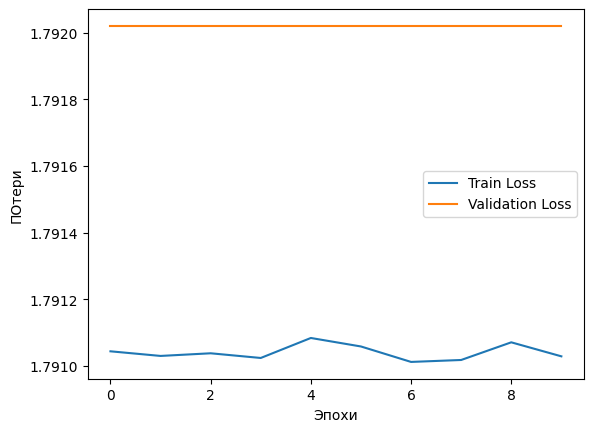

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

In [ ]:
import torch.optim as optim

# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Валидация на валидационной выборке
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Обучение модели
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)